In [1]:
%reload_ext autoreload
%autoreload 2

In [23]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPool1D, Embedding, Concatenate, Permute, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import tensorflow as tf

import pandas as pd
import numpy as np
import bpe

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

# set GPU

In [30]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.Session(config=config)
    K.set_session(session)

# funcs for assessment

In [26]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [27]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# load dataset with chunks (wrap) 5 to 30

In [3]:
data = pd.read_csv('./data/dataset_wrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


### create input_ids from BPE and categorical target

In [4]:
encoder = bpe.Encoder.load('./models/bpe_tokenizer.h5')

In [14]:
encoder.bpe_vocab, encoder.bpe_vocab_size, encoder.word_vocab, encoder.vocab_size

({'__eow': 250,
  '__sow': 251,
  'g': 252,
  'a': 253,
  'c': 254,
  't': 255,
  'ag': 256,
  'ca': 257,
  'tg': 258,
  'cc': 259,
  'ga': 260,
  'gg': 261,
  'aa': 262,
  'ct': 263,
  'gc': 264,
  'tc': 265,
  'ac': 266,
  'at': 267,
  'tt': 268,
  'gt': 269,
  'ta': 270,
  'cg': 271,
  'cag': 272,
  'ctg': 273,
  'aga': 274,
  'tgg': 275,
  'cca': 276,
  'gga': 277,
  'gaa': 278,
  'gag': 279,
  'aag': 280,
  'cct': 281,
  'aaa': 282,
  'gcc': 283,
  'agc': 284,
  'ccc': 285,
  'agg': 286,
  'tga': 287,
  'ggc': 288,
  'gct': 289,
  'gca': 290,
  'tgc': 291,
  'caa': 292,
  'atg': 293,
  'aca': 294,
  'tca': 295,
  'gtg': 296,
  'tcc': 297,
  'ctc': 298,
  'acc': 299,
  'ggg': 300,
  'cac': 301,
  'tct': 302,
  'ttc': 303,
  'ctt': 304,
  'cat': 305,
  'gac': 306,
  'tgt': 307,
  'gat': 308,
  'aac': 309,
  'ttt': 310,
  'agt': 311,
  'ttg': 312,
  'atc': 313,
  'act': 314,
  'aat': 315,
  'att': 316,
  'ggt': 317,
  'gtc': 318,
  'ccg': 319,
  'cgg': 320,
  'gtt': 321,
  'tac': 322

In [5]:
def tokens_to_ids(encoder, x):
    x_toks = []
    for i in range(len(x)):
        encoder.tokenize(x[i])
        x_toks.append(next(encoder.transform([x[i]])))
    
    max_len = max(map(len, x_toks))
    X_arr = np.zeros((len(x_toks), max_len), dtype='int32')
    for i, s in enumerate(x_toks):
        X_arr[i, 0:len(s)] = s
    
    return X_arr

X_toks = tokens_to_ids(encoder, data.seq.values)

In [6]:
max(map(max,X_toks)), min(map(min,X_toks))

(499, 0)

In [7]:
MAXCHARSLEN = max(map(len, data.seq.values))
MAXSEQLEN = max(map(len, X_toks))
MAXCHARSLEN, MAXSEQLEN

(30, 12)

In [8]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

import sys
sys.path.append('./src')
from PreprocInput import preproc_

In [10]:
X_ids, y_ids = preproc_.get_input_array(data.seq.values, data.label.values, MAXCHARSLEN, chars, char_indices)

In [13]:
X_toks.shape, y_ids.shape, X_ids.shape

((3351352, 12), (3351352, 4), (3351352, 30, 4))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_toks, y_ids, random_state=42, shuffle=True, test_size=0.2)
X_train_cat, X_test_cat, _, _ = train_test_split(X_ids, y_ids, random_state=42, shuffle=True, test_size=0.2)

# build and train model: Emb+Bilstm+maxpool_batchnorm

In [21]:
def get_model(vocab_size, n_classes, seq_len_emb, seq_len_chars):
    
    inp = Input(shape =(seq_len_emb,), name='Input1')
    emb = Embedding(vocab_size, 256, name='BPE_emb')(inp)
    x = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2), name='BiLSTM')(emb)
    ###
    inp2 = Input(shape = (seq_len_chars, n_classes), name='Input2')
    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="relu",
                name='Conv1d-1')(inp2)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-1')(y)
    y = BatchNormalization(name='BatchNorm-1')(y)

    y = Conv1D(kernel_size=3,
                filters=128,
                padding='valid',
                activation="tanh",
                name='Conv1d-2')(y)
    y = MaxPool1D(pool_size=2, strides=2, name='MaxPool1d-2')(y)
    y = BatchNormalization(name='BatchNorm-2')(y)

    y = Dropout(0.2, name='Dropout_0.2')(y)
    y = Flatten(name='Flatten')(y)
    ###
    comb = Concatenate(name='Concat')([x,y])

    z = Dense(128, activation='tanh', name='Dense_128')(comb)
    z = Dense(n_classes, activation='softmax', name='Dense_NCLASS')(z)
    model = Model(inputs=[inp, inp2], outputs=z)
    plot_model(model = model, to_file = './same_/BiLSTM+emb-CNN.png', show_layer_names=False, show_shapes=True)
    model.summary()
    
    return model

In [32]:
VOCAB_SIZE = encoder.vocab_size

model = get_model(vocab_size = VOCAB_SIZE, n_classes=len(chars), seq_len_emb=MAXSEQLEN, seq_len_chars=MAXCHARSLEN)

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input2 (InputLayer)             (None, 30, 4)        0                                            
__________________________________________________________________________________________________
Conv1d-1 (Conv1D)               (None, 28, 128)      1664        Input2[0][0]                     
__________________________________________________________________________________________________
MaxPool1d-1 (MaxPooling1D)      (None, 14, 128)      0           Conv1d-1[0][0]                   
__________________________________________________________________________________________________
BatchNorm-1 (BatchNormalization (None, 14, 128)      512         MaxPool1d-1[0][0]                
__________________________________________________________________________________________________
Conv1d-2 (

In [ ]:
path = './same_/bilstm_emb_cnn.h5'

callbacks = [EarlyStopping(patience=10, monitor='val_loss'),
             ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit([X_train, X_train_cat], y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

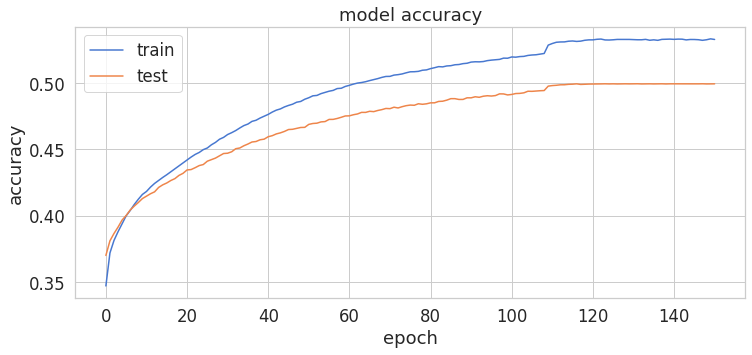

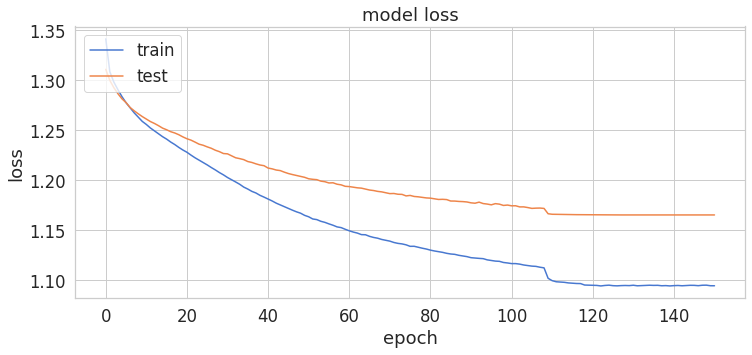

In [34]:
plot_metrics(history)

# load model and print metrics

In [52]:
model = load_model(path)

In [36]:
y_pred = model.predict([X_test, X_test_cat])
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

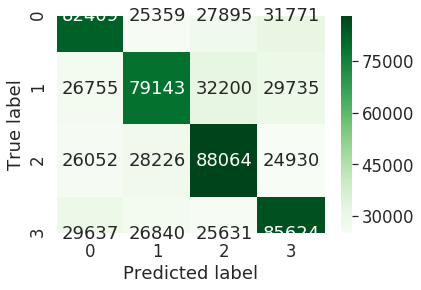

In [37]:
confusion_matrix_heatmap(y_true, y_pred)

In [38]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.49      0.50    167434
           1       0.50      0.47      0.48    167833
           2       0.51      0.53      0.52    167272
           3       0.50      0.51      0.50    167732

    accuracy                           0.50    670271
   macro avg       0.50      0.50      0.50    670271
weighted avg       0.50      0.50      0.50    670271

